In [124]:
import argparse
import logging
import os
import pprint
import threading
import time
import timeit
import traceback
import typing

os.environ["OMP_NUM_THREADS"] = "1"  # Necessary for multithreading.

import torch
from torch import multiprocessing as mp
from torch.multiprocessing import Process, Manager
from torch import nn
from torch.nn import functional as F

from torchbeast.core.environment import Environment, Vec_Environment
from torchbeast.atari_wrappers import SokobanWrapper
from torchbeast.base import BaseNet
from torchbeast.train import create_env

import gym
import gym_sokoban
import numpy as np
import math
import logging
from matplotlib import pyplot as plt
from collections import deque

logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

torch.multiprocessing.set_sharing_strategy('file_system')

def get_param(net, name=None):
    keys = []
    for (k, v) in actor_wrapper.model.named_parameters(): 
        if name is None:
            print(k)
        else:
            if name == k: return v
        keys.append(k)
    return keys        

def n_step_greedy(env, net, n, temp=10.):    
    if isinstance(env, Vec_Environment):
        num_actions = env.gym_env.action_space[0].n
        bsz = len(env.gym_env.envs)
    else:
        num_actions = env.gym_env.action_space.n
        bsz = 1

    q_ret = torch.zeros(bsz, num_actions).to(device)      
    state = env.clone_state()

    for act in range(num_actions):
        obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
        obs = {k:v.to(device) for k, v in obs.items()}   
        
        if n > 1:
            action, prob, sub_q_ret = n_step_greedy(env, net, n-1)
            ret = obs['reward'] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] * (~obs['done']).float()
        else:
            ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()

        q_ret[:, act] = ret
        env.restore_state(state)
    
    prob = F.softmax(temp*q_ret, dim=1)
    action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret  


<font size="5">Testing planning algo. for perfect model with bootstrapped values</font>

In [3]:
# Synchronous version of testing 

def test_n_step(n, net, env, temp=10.):
    
    print("Testing %d step planning" % n)

    returns = []
    obs = env.initial()
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        cur_returns = obs['episode_return']    
        obs = {k:v.to(device) for k, v in obs.items()}
        net_out, core_state = net(obs)            
        if n == 0:
            action = net_out["action"][0]
        else:
            action, _, _ = n_step_greedy(env, net, n, temp)
        obs = env.step(action)
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 10
            print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
            
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

bsz = 16    
eps_n = 500
device = torch.device("cuda")

# create environments

env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
num_actions = env.gym_env.action_space[0].n

# import the net

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   
flags.discounting = 0.97
temp = 5

net = BaseNet(observation_shape=(3,80,80), num_actions=num_actions, flags=flags)  
net = net.to(device)
checkpoint = torch.load("../models/base_1.tar", map_location="cuda")
#checkpoint = torch.load("/home/schk/RS/thinker/logs/base/torchbeast-20221105-033530/model.tar", map_location="cuda")
net.load_state_dict(checkpoint["model_state_dict"]) 

# initialize net

core_state = net.initial_state(batch_size=bsz)
core_state = tuple(v.to(device) for v in core_state)
net.train(False)

all_returns = {}
for n in range(0,4):
    t = time.process_time()
    all_returns[n] = test_n_step(n, net, env, temp)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

model size:  1095814
Testing 0 step planning
Finish 16 episode: avg. return: -0.07 (+-0.17) 
Finish 32 episode: avg. return: 0.18 (+-0.16) 
Finish 48 episode: avg. return: 0.09 (+-0.14) 
Finish 64 episode: avg. return: 0.13 (+-0.11) 
Finish 80 episode: avg. return: 0.31 (+-0.19) 
Finish 96 episode: avg. return: 0.35 (+-0.21) 
Finish 112 episode: avg. return: 0.29 (+-0.19) 
Finish 128 episode: avg. return: 0.27 (+-0.16) 
Finish 144 episode: avg. return: 0.27 (+-0.15) 
Finish 160 episode: avg. return: 0.25 (+-0.13) 
Finish 176 episode: avg. return: 0.22 (+-0.12) 
Finish 192 episode: avg. return: 0.18 (+-0.12) 
Finish 208 episode: avg. return: 0.18 (+-0.11) 
Finish 224 episode: avg. return: 0.21 (+-0.12) 
Finish 240 episode: avg. return: 0.23 (+-0.12) 
Finish 256 episode: avg. return: 0.21 (+-0.12) 
Finish 272 episode: avg. return: 0.21 (+-0.11) 
Finish 288 episode: avg. return: 0.18 (+-0.11) 
Finish 304 episode: avg. return: 0.20 (+-0.10) 
Finish 320 episode: avg. return: 0.18 (+-0.10) 


KeyboardInterrupt: 

In [ ]:
# Asynchronous version of testing 

def act_m(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    returns: Manager().list,
    eps_n: int,
    n: int,
    temp: float,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        net_out, unused_state = net(env_output, agent_state)      
        while True:            
            if len(returns) >= eps_n: break
            with torch.no_grad():
                net_out, agent_state = net(env_output, agent_state)                            
            if n == 0:
                action = net_out["action"]
            else:
                action, _, _ = n_step_greedy(env, net, n, temp)            
            env_output = env.step(action)           
            if env_output['done']: returns.append(ret)
            ret = env_output['episode_return'].item()        
        #logging.info("Actor %i end", actor_index)
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e

def asy_test_n_step(n, net, flags, temp):
    
    print("Testing %d step planning" % n)

    mp.set_sharing_strategy('file_system')
    net.share_memory()
    ctx = mp.get_context()        
    returns = Manager().list()

    actor_processes = []
    for i in range(flags.num_actors):
        actor = ctx.Process(target=act_m, args=(flags, i, net, returns, eps_n, n, temp),)
        actor.start()
        actor_processes.append(actor)    

    for actor in actor_processes:
        actor.join()    

    print("Finish %d episode: avg. return: %.2f (+-%.2f)" % (len(returns),
                    np.average(returns), np.std(returns) / np.sqrt(len(returns)),))        
    return returns        
        
parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97     
flags.num_actors = 32
bsz = 1
eps_n = 500
temp = 5
device = torch.device("cpu")

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
net = net.to("cpu")
checkpoint = torch.load("/home/schk/RS/thinker/models/base_2.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"]) 

all_returns = {}
for n in range(4):
    t = time.time()
    all_returns[n] = asy_test_n_step(n, net, flags, temp)
    print("Time required for %d step planning: %f" %(n, time.time()-t))

Results (base_1.tar):
    
Testing 0 step planning <br>
Finish 512 episode: avg. return: 0.12 (+-0.06) <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.61 (+-0.04) <br>
Testing 2 step planning <br>
Finish 501 episode: avg. return: 0.92 (+-0.04) <br>
Testing 3 step planning <br>
Finish 501 episode: avg. return: 1.01 (+-0.04) <br>

Results (base_2.tar):
Testing 0 step planning <br>
Finish 500 episode: avg. return: 0.27 (+-0.04) <br>
Time required for 0 step planning: 12.629324 <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.51 (+-0.04) <br>
Time required for 1 step planning: 74.194364 <br>
Testing 2 step planning <br>
Finish 500 episode: avg. return: 0.74 (+-0.04) <br>
Time required for 2 step planning: 339.732901 <br>
Testing 3 step planning <br>
Finish 500 episode: avg. return: 0.76 (+-0.04) <br>
Time required for 3 step planning: 1695.472523 <br>

<font size="5">Model Training Phase</font>

In [178]:
# Generating data for learning model [RUN]

Buffers = typing.Dict[str, typing.List[torch.Tensor]]

def create_buffers_m(flags, obs_shape, num_actions) -> Buffers:
    
    seq_len = flags.seq_len
    seq_n = flags.seq_n
    specs = dict(
        frame=dict(size=(seq_len + 1, *obs_shape), dtype=torch.uint8),
        reward=dict(size=(seq_len + 1,), dtype=torch.float32),
        done=dict(size=(seq_len + 1,), dtype=torch.bool),
        truncated_done=dict(size=(seq_len + 1,), dtype=torch.bool),
        episode_return=dict(size=(seq_len + 1,), dtype=torch.float32),
        episode_step=dict(size=(seq_len + 1,), dtype=torch.int32),
        policy_logits=dict(size=(seq_len + 1, num_actions), dtype=torch.float32),
        baseline=dict(size=(seq_len + 1,), dtype=torch.float32),
        last_action=dict(size=(seq_len + 1,), dtype=torch.int64),
        action=dict(size=(seq_len + 1,), dtype=torch.int64),
        reg_loss=dict(size=(seq_len + 1,), dtype=torch.float32)
    )
    buffers: Buffers = {key: [] for key in specs}
    for _ in range(seq_n):
        for key in buffers:
            buffers[key].append(torch.empty(**specs[key]).share_memory_())
            
    return buffers

def gen_data(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    buffers: Buffers,
    free_queue: mp.SimpleQueue,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        agent_output, unused_state = net(env_output, agent_state)     
        
        while True:
            index = free_queue.get()
            if index is None:
                break         

            # Write old rollout end.
            for key in env_output:
                buffers[key][index][0, ...] = env_output[key]
            for key in agent_output:
                buffers[key][index][0, ...] = agent_output[key]

            # Do new rollout.
            for t in range(flags.seq_len):
                with torch.no_grad():
                    agent_output, agent_state = net(env_output, agent_state)
                env_output = env.step(agent_output["action"])
                for key in env_output:
                    buffers[key][index][t + 1, ...] = env_output[key]
                for key in agent_output:
                    buffers[key][index][t + 1, ...] = agent_output[key]
                    
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e
        

# Models

DOWNSCALE_C = 2

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation,
        groups=groups, bias=False, dilation=dilation,)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, outplanes=None):
        super().__init__()
        if outplanes is None: outplanes = inplanes 
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(inplanes, outplanes)
        self.bn2 = norm_layer(outplanes)
        self.skip_conv = (outplanes != inplanes)
        if outplanes != inplanes:
            self.conv3 = conv1x1(inplanes, outplanes)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.skip_conv:
            out += self.conv3(identity)
        else:
            out += identity
        out = self.relu(out)
        return out
    
class FrameEncoder(nn.Module):    
    def __init__(self, num_actions, frame_channels=3, type_nn=0):
        self.num_actions = num_actions
        super(FrameEncoder, self).__init__() 
        
        if type_nn == 0:
            n_block = 1
        elif type_nn == 1:
            n_block = 2
        
        self.conv1 = nn.Conv2d(in_channels=frame_channels+num_actions, out_channels=128//DOWNSCALE_C, kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=128//DOWNSCALE_C) for i in range(n_block)]) # Deep: 2 blocks here
        self.res1 = torch.nn.Sequential(*res)
        self.conv2 = nn.Conv2d(in_channels=128//DOWNSCALE_C, out_channels=256//DOWNSCALE_C, 
                               kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(n_block)]) # Deep: 3 blocks here
        self.res2 = torch.nn.Sequential(*res)
        self.avg1 = nn.AvgPool2d(3, stride=2, padding=1)
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(n_block)]) # Deep: 3 blocks here
        self.res3 = torch.nn.Sequential(*res)
        self.avg2 = nn.AvgPool2d(3, stride=2, padding=1)
    
    def forward(self, x, actions):        
        # input shape: B, C, H, W        
        # action shape: B 
        
        x = x.float() / 255.0    
        actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
        x = torch.concat([x, actions], dim=1)
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = F.relu(self.conv2(x))
        x = self.res2(x)
        x = self.avg1(x)
        x = self.res3(x)
        x = self.avg2(x)
        return x
    
class DynamicModel(nn.Module):
    def __init__(self, num_actions, inplanes=256, type_nn=0):        
        super(DynamicModel, self).__init__()
        self.type_nn = type_nn
        if type_nn == 0:
            res = nn.ModuleList([ResBlock(inplanes=inplanes+num_actions, outplanes=inplanes)] + [
                    ResBlock(inplanes=inplanes) for i in range(4)]) 
        elif type_nn == 1:                      
            res = nn.ModuleList([ResBlock(inplanes=inplanes) for i in range(15)] + [
                    ResBlock(inplanes=inplanes, outplanes=inplanes*num_actions)])

        
        self.res = torch.nn.Sequential(*res)
        self.num_actions = num_actions
    
    def forward(self, x, actions):              
        bsz, c, h, w = x.shape
        if self.training:
            x.register_hook(lambda grad: grad * 0.5)
        if self.type_nn == 0:
            actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
            x = torch.concat([x, actions], dim=1)
            out = self.res(x)
        elif self.type_nn == 1:            
            res_out = self.res(x).view(bsz, self.num_actions, c, h, w)        
            actions = actions.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            out = torch.sum(actions * res_out, dim=1)
        return out
    
class Output_rvpi(nn.Module):   
    def __init__(self, num_actions, input_shape):         
        super(Output_rvpi, self).__init__()        
        c, h, w = input_shape
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=c//2, kernel_size=3, padding='same') 
        self.conv2 = nn.Conv2d(in_channels=c//2, out_channels=c//4, kernel_size=3, padding='same') 
        fc_in = h * w * (c // 4)
        self.fc_r = nn.Linear(fc_in, 1) 
        self.fc_v = nn.Linear(fc_in, 1) 
        self.fc_logits = nn.Linear(fc_in, num_actions)         
        
    def forward(self, x):    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        r, v, logits = self.fc_r(x), self.fc_v(x), self.fc_logits(x)
        return r, v, logits

class Model(nn.Module):    
    def __init__(self, flags, obs_shape, num_actions):        
        super(Model, self).__init__()      
        self.flags = flags
        self.obs_shape = obs_shape
        self.num_actions = num_actions          
        self.type_nn = flags.model_type_nn # type_nn: type of neural network for the model; 0 for small, 1 for large
        self.frameEncoder = FrameEncoder(num_actions=num_actions, frame_channels=obs_shape[0], type_nn=self.type_nn)
        self.dynamicModel = DynamicModel(num_actions=num_actions, inplanes=256//DOWNSCALE_C, type_nn=self.type_nn)
        self.output_rvpi = Output_rvpi(num_actions=num_actions, input_shape=(256//DOWNSCALE_C, 
                      obs_shape[1]//16, obs_shape[1]//16))
        
    def forward(self, x, actions, one_hot=False):
        # Input
        # x: frames with shape (B, C, H, W), in the form of s_t
        # actions: action (int64) with shape (k+1, B), in the form of a_{t-1}, a_{t}, a_{t+1}, .. a_{t+k-1}
        # Output
        # reward: predicted reward with shape (k, B), in the form of r_{t+1}, r_{t+2}, ..., r_{t+k}
        # value: predicted value with shape (k+1, B), in the form of v_{t}, v_{t+1}, v_{t+2}, ..., v_{t+k}
        # policy: predicted policy with shape (k+1, B), in the form of pi_{t}, pi_{t+1}, pi_{t+2}, ..., pi_{t+k}
        # encoded: encoded states with shape (k+1, B), in the form of z_t, z_{t+1}, z_{t+2}, ..., z_{t+k}
        # Recall the transition notation: s_t, a_t, r_{t+1}, s_{t+1}, ...
        
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        encoded = self.frameEncoder(x, actions[0])
        return self.forward_encoded(encoded, actions[1:], one_hot=True)
    
    def forward_encoded(self, encoded, actions, one_hot=False):
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        
        r, v, logits = self.output_rvpi(encoded)
        r_list, v_list, logits_list = [], [v.squeeze(-1).unsqueeze(0)], [logits.unsqueeze(0)]
        encoded_list = [encoded.unsqueeze(0)]
        
        for k in range(actions.shape[0]):            
            encoded = self.dynamicModel(encoded, actions[k])
            r, v, logits = self.output_rvpi(encoded)
            r_list.append(r.squeeze(-1).unsqueeze(0))
            v_list.append(v.squeeze(-1).unsqueeze(0))
            logits_list.append(logits.unsqueeze(0))
            encoded_list.append(encoded.unsqueeze(0))        
        
        if len(r_list) > 0:
            rs = torch.concat(r_list, dim=0)
        else:
            rs = None
            
        vs = torch.concat(v_list, dim=0)
        logits = torch.concat(logits_list, dim=0)
        encodeds = torch.concat(encoded_list, dim=0)        
        
        return rs, vs, logits, encodeds

#model = Model(flags, (3, 80, 80), num_actions=5)
#rs, vs, logits = model(torch.rand(16, 3, 80, 80), torch.ones(8, 16).long())

# functions for training models

def get_batch_m(flags, buffers: Buffers):
    batch_indices = np.random.randint(flags.seq_n, size=flags.bsz)
    time_indices = np.random.randint(flags.seq_len - flags.unroll_len, size=flags.bsz)
    batch = {key: torch.stack([buffers[key][m][time_indices[n]:time_indices[n]+flags.unroll_len+1] 
                          for n, m in enumerate(batch_indices)], dim=1) for key in buffers}
    batch = {k: t.to(device=flags.device, non_blocking=True) for k, t in batch.items()}
    return batch

def compute_cross_entropy_loss(logits, target_logits, mask):
    target_policy = F.softmax(target_logits, dim=-1)
    log_policy = F.log_softmax(logits, dim=-1)
    return -torch.sum(target_policy * log_policy * (~mask).float().unsqueeze(-1))

def compute_loss_m(model, batch):
    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_rewards = batch['reward'][1:]
    target_logits = batch['policy_logits'][1:]

    target_vs = []
    target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float())# +
                           #vs[t-1] * (batch['truncated_done'][t]).float())
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)

    # if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
    # rs is stored in the form of r_{t+1}, ..., r_{t+k}
    # vs is stored in the form of v_{t}, ..., v_{t+k-1}
    # logits is stored in the form of a{t}, ..., a_{t+k-1}

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
    for t in range(vs.shape[0]):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        done_masks.append(done.unsqueeze(0))

    done_masks = torch.concat(done_masks[:-1], dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    #rs_loss = torch.sum(huberloss(rs, target_rewards.detach()) * (~done_masks).float())
    rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~done_masks).float())
    #vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()) * (~done_masks).float())
    vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), done_masks)
    
    return rs_loss, vs_loss, logits_loss

# n-step exhaustive search

def n_step_greedy_model(state, action, model, n, encoded=None, temp=20.): 
    
    # Either input state, action (S_t, A_{t-1}) or the encoded Z_t
    # state / encoded in the shape of (B, C, H, W)
    # action in the shape of (B)    
    with torch.no_grad():    
      bsz = state.shape[0] if encoded is None else encoded.shape[0]
      device = state.device if encoded is None else encoded.device
      num_actions = model.num_actions    

      q_ret = torch.zeros(bsz, num_actions).to(device)        

      for act in range(num_actions):        
          new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
          if encoded is None:            
              old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
              rs, vs, logits, encodeds = model(state, old_new_actions)
          else:
              rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0))

          if n > 1:
              action, prob, sub_q_ret = n_step_greedy_model(state=None, action=None, 
                         model=model, n=n-1, encoded=encodeds[1])
              ret = rs[0] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] 
              #ret = rs[0] + flags.discounting * torch.mean(sub_q_ret, dim=1)
          else:
              ret = rs[0] + flags.discounting * vs[1]
          q_ret[:, act] = ret

      prob = F.softmax(temp*q_ret, dim=1)
      action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret        
   
# d-step n-rollout search   
    
def n_d_uniform_rollout(state, action, model, n, d, temp):

    # state in the shape of (B, C, H, W)
    # action in the shape of (B)    
    # n: number of rollout
    # d: depth of rollout
    # temp: temperature 
    
    with torch.no_grad():    
        bsz = state.shape[0]
        device = state.device 
        num_actions = model.num_actions    
        rollout_ret = torch.zeros(bsz, n).to(device)      
        initial_action = torch.zeros(bsz, n, dtype=torch.long).to(device)      
        for rollout_n in range(n):
            new_action = torch.multinomial(torch.tensor(np.full((bsz, num_actions), 1/num_actions)), num_samples=1)  
            new_action = new_action[:,0].to(device)  
            initial_action[:, rollout_n] = new_action
            old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
            rs, vs, logits, encodeds = model(state, old_new_actions, one_hot=False)
            encoded = encodeds[-1]
            ret = rs[0]
            c_discount = flags.discounting
            for rollout_d in range(d - 1):            
                new_action = torch.multinomial(torch.tensor(np.full((bsz, num_actions), 1/num_actions)), num_samples=1)  
                new_action = new_action[:,0].to(device) 
                rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0), one_hot=False)
                encoded = encodeds[-1]
                ret = ret + c_discount * rs[0]
                c_discount = c_discount * flags.discounting
            ret = ret + c_discount * vs[1]
            rollout_ret[:, rollout_n] = ret
        prob = torch.softmax(temp*rollout_ret, dim=-1)
        sel = torch.multinomial(prob, num_samples=1)[:,0]  
        action = initial_action[np.arange(bsz), sel]
    return action

# MCTS testing

class MCTS:
    """
    Core Monte Carlo Tree Search algorithm.
    To decide on an action, we run N simulations, always starting at the root of
    the search tree and traversing the tree according to the UCB formula until we
    reach a leaf node.
    """
    def __init__(self, flags, num_actions):
        self.flags = flags
        self.num_actions = num_actions

    def run(self, model, obs, add_exploration_noise,):
        """
        At the root of the search tree we use the representation function to obtain a
        hidden state given the current observation.
        We then run a Monte Carlo Tree Search using only action sequences and the model
        learned by the network.
        Only supports a batch size of 1.        
        """
        with torch.no_grad():
            root = Node(0)
            _, root_predicted_value, policy_logits, hidden_state = model(
                obs["frame"][0], obs["last_action"], one_hot=False)
            reward = 0.
            root_predicted_value = root_predicted_value[-1].item()
            policy_logits = policy_logits[-1]
            hidden_state = hidden_state[-1]

            root.expand(num_actions, reward, policy_logits, hidden_state,)

            if add_exploration_noise:
                root.add_exploration_noise(
                    dirichlet_alpha=self.flags.root_dirichlet_alpha,
                    exploration_fraction=self.flags.root_exploration_fraction,
                )

            min_max_stats = MinMaxStats()

            max_tree_depth = 0
            
            #print("p at root:", torch.softmax(policy_logits, dim=-1))
            for k in range(self.flags.num_simulations): 
                
                #print("=======%d iteration======"%k)
                node = root
                search_path = [node]
                current_tree_depth = 0

                while node.expanded():
                    current_tree_depth += 1                    
                    action, node = self.select_child(node, min_max_stats)                    
                    search_path.append(node)
                    #print("action sel: %d" % action)
                
                #np.set_printoptions(precision=5)
                #for x in ["prior_score", "value_score", "pb_c", "prior", "visit_count"]:                    
                #    print(x, "\t", np.array([getattr(search_path[0].children[n], x) for n in range(5)]))

                # Inside the search tree we use the dynamics function to obtain the next hidden
                # state given an action and the previous hidden state
                parent = search_path[-2]     
                reward, value, policy_logits, hidden_state = model.forward_encoded(
                    parent.hidden_state, torch.tensor([[action]]).to(parent.hidden_state.device), one_hot=False)
                reward = reward[-1].item()
                value = value[-1].item()
                #print("model final output: %4f" % value)
                policy_logits = policy_logits[-1]
                hidden_state = hidden_state[-1]
                node.expand(num_actions, reward, policy_logits, hidden_state)
                self.backpropagate(search_path, value, min_max_stats)
                max_tree_depth = max(max_tree_depth, current_tree_depth)

            extra_info = {
                "max_tree_depth": max_tree_depth,
                "root_predicted_value": root_predicted_value,
            }
        return root, extra_info

    def select_child(self, node, min_max_stats):
        """
        Select the child with the highest UCB score.
        """
        max_ucb = max(
            self.ucb_score(node, child, min_max_stats)
            for action, child in node.children.items()
        )
        action = np.random.choice(
            [
                action
                for action, child in node.children.items()
                if self.ucb_score(node, child, min_max_stats) == max_ucb
            ]
        )
        return action, node.children[action]

    def ucb_score(self, parent, child, min_max_stats):
        """
        The score for a node is based on its value, plus an exploration bonus based on the prior.
        """
        pb_c = (
            math.log(
                (parent.visit_count + self.flags.pb_c_base + 1) / self.flags.pb_c_base
            )
            + self.flags.pb_c_init
        )
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

        prior_score = pb_c * child.prior

        if child.visit_count > 0:
            # Mean value Q
            value_score = min_max_stats.normalize(
                child.reward + self.flags.discounting * child.value())
        else:
            value_score = 0
            
        child.pb_c = pb_c
        child.prior_score = prior_score
        child.value_score = value_score
        
        return prior_score + value_score

    def backpropagate(self, search_path, value, min_max_stats):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        #print("bs value: %.4f" % value)
        for n, node in enumerate(reversed(search_path)):
            node.value_sum += value
            node.visit_count += 1
            min_max_stats.update(node.reward + self.flags.discounting * node.value())
            value = node.reward + self.flags.discounting * value
            #print("%d - val: %.4f r: %.4f" % (n, value, node.reward))
            #print("node value_sum %.4f" % node.value_sum)

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def expand(self, num_actions, reward, policy_logits, hidden_state):
        """
        We expand a node using the value, reward and policy prediction obtained from the
        neural network.
        """
        self.reward = reward
        self.hidden_state = hidden_state
        policy_values = torch.softmax(policy_logits[0], dim=0).tolist()
        for a in range(num_actions):
            self.children[a] = Node(policy_values[a])

    def add_exploration_noise(self, dirichlet_alpha, exploration_fraction):
        """
        At the start of each search, we add dirichlet noise to the prior of the root to
        encourage the search to explore new actions.
        """
        actions = list(self.children.keys())
        noise = np.random.dirichlet([dirichlet_alpha] * len(actions))
        frac = exploration_fraction
        for a, n in zip(actions, noise):
            self.children[a].prior = self.children[a].prior * (1 - frac) + n * frac

class MinMaxStats:
    """
    A class that holds the min-max values of the tree.
    """

    def __init__(self):
        self.maximum = -float("inf")
        self.minimum = float("inf")

    def update(self, value):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value):
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value            

def select_action(node, temperature):
    """
    Select action according to the visit count distribution and the temperature.
    The temperature is changed dynamically with the visit_softmax_temperature function
    in the config.
    """
    visit_counts = np.array(
        [child.visit_count for child in node.children.values()], dtype="int32"
    )
    actions = [action for action in node.children.keys()]
    if temperature == 0:
        action = actions[np.argmax(visit_counts)]
    elif temperature == float("inf"):
        action = np.random.choice(actions)
    else:
        # See paper appendix Data Generation
        visit_count_distribution = visit_counts ** (1 / temperature)
        visit_count_distribution = visit_count_distribution / sum(
            visit_count_distribution
        )
        action = np.random.choice(actions, p=visit_count_distribution)
    #print("visit_counts", visit_counts)
    #print("visit_count_distribution", visit_count_distribution)
    return action

def test_model(n, model, flags, eps_n=100, temp=20., mode=0, **kwargs):   
    # mode 0 for n-step exhuastive search
    # mode 1 for d-step n-rollout uniform search
    # mode 2 for MCTS
    
    bsz = 100 if mode != 2 else 1
    env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
    env = Vec_Environment(env, bsz)
    num_actions = env.gym_env.action_space[0].n
    
    if mode == 0:
        print("Testing %d-step exhaustive planning" % n) 
    elif mode == 1:
        d = kwargs["d"]
        print("Testing %d-step %d-rollout planning" % (d, n))
    elif mode == 2:
        mcts = MCTS(kwargs["mcts_flags"], num_actions)
        print("Testing MCTS with %d simulations" % kwargs["mcts_flags"].num_simulations)
    else:
        raise Exception("Not implemented")
    
    model.train(False)
    returns = []
    
    obs = env.initial()
    action = torch.zeros(bsz).long().to(flags.device)
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        cur_returns = obs['episode_return']    
        obs = {k:v.to(flags.device) for k, v in obs.items()}
        if mode == 0:
            new_action, _, _ = n_step_greedy_model(obs['frame'][0], action, model, n, None, temp)        
        elif mode == 1:
            new_action = n_d_uniform_rollout(obs['frame'][0], action, model, n, d, temp)     
        elif mode == 2:
            root, extra_info = mcts.run(model, obs, add_exploration_noise=True)                
            new_action = torch.tensor([select_action(root, temp)]).long()
        obs = env.step(new_action)
        action = new_action
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 10
            #print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            #    np.average(returns), np.std(returns) / np.sqrt(len(returns))))
            
    returns = returns[:eps_n]
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

In [126]:
# Start training models

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())       

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.bsz = 64
flags.unroll_len = 5
flags.num_actors = 32
flags.seq_n = 1000
flags.seq_len = 200
flags.learning_rate = 0.0001
flags.loop_batch_n = 3
flags.discounting = 0.97
flags.tot_epoch = 10000
flags.grad_norm_clipping = 60

flags.model_type_nn = 0
flags.device = torch.device("cuda")

# Create buffer for actors to write

mp.set_sharing_strategy('file_system')
ctx = mp.get_context()        

env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n
buffers = create_buffers_m(flags, obs_shape, num_actions)
print("Buffer created successfully.")

# Initialize the model and optimizer

env = create_env(flags)
model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
optimizer = torch.optim.Adam(model.parameters(), lr=flags.learning_rate)

print("model size: ", sum(p.numel() for p in model.parameters()))
for k, v in model.named_parameters(): print(k, v.numel())    
    
tot_step = int(flags.loop_batch_n * flags.seq_n * flags.seq_len / flags.bsz / flags.unroll_len) 

Buffer created successfully.
model size:  2352882
frameEncoder.conv1.weight 4608
frameEncoder.conv1.bias 64
frameEncoder.res1.0.conv1.weight 36864
frameEncoder.res1.0.bn1.weight 64
frameEncoder.res1.0.bn1.bias 64
frameEncoder.res1.0.conv2.weight 36864
frameEncoder.res1.0.bn2.weight 64
frameEncoder.res1.0.bn2.bias 64
frameEncoder.conv2.weight 73728
frameEncoder.conv2.bias 128
frameEncoder.res2.0.conv1.weight 147456
frameEncoder.res2.0.bn1.weight 128
frameEncoder.res2.0.bn1.bias 128
frameEncoder.res2.0.conv2.weight 147456
frameEncoder.res2.0.bn2.weight 128
frameEncoder.res2.0.bn2.bias 128
frameEncoder.res3.0.conv1.weight 147456
frameEncoder.res3.0.bn1.weight 128
frameEncoder.res3.0.bn1.bias 128
frameEncoder.res3.0.conv2.weight 147456
frameEncoder.res3.0.bn2.weight 128
frameEncoder.res3.0.bn2.bias 128
dynamicModel.res.0.conv1.weight 159201
dynamicModel.res.0.bn1.weight 133
dynamicModel.res.0.bn1.bias 133
dynamicModel.res.0.conv2.weight 153216
dynamicModel.res.0.bn2.weight 128
dynamicModel

In [ ]:
temp = 20

# Load the preset policy

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
checkpoint = torch.load("/home/sc/RS/thinker/models/base_1.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"])   
net.train(False)
net.share_memory()

# Get the actors to write on the buffer

actor_processes = []
free_queue = mp.SimpleQueue()
loss_stats = [deque(maxlen=400) for _ in range(4)]

net.train(False)
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

# Start training loop    

model.train(True)
for epoch in range(flags.tot_epoch):    
    print("Batch [%d] starts" % epoch)
    while(not free_queue.empty()): time.sleep(1)
    for step in range(tot_step):
        if step == 0: 
            test_model(1, model, flags, eps_n=100, temp=temp)
            test_model(2, model, flags, eps_n=100, temp=temp)
            model.train(True)
        
        batch = get_batch_m(flags, buffers)
        rs_loss, vs_loss, logits_loss = compute_loss_m(model, batch)
        tot_loss = rs_loss + vs_loss + 0.01 * logits_loss
        for n, l in enumerate([tot_loss, rs_loss, vs_loss, logits_loss]):
            loss_stats[n].append(l.item())
        
        if step % 100 == 0:
            print("[%d:%d] F: %d \t tot_loss %f rs_loss %f vs_loss %f logits_loss %f" % ((
                epoch, step, (step + epoch * tot_step) * flags.bsz * flags.unroll_len,) +
                tuple(np.average(l) for l in loss_stats)))
        optimizer.zero_grad()        
        tot_loss.backward()
        optimize_params = optimizer.param_groups[0]['params']
        if flags.grad_norm_clipping > 0:
            total_norm = nn.utils.clip_grad_norm_(optimize_params, flags.grad_norm_clipping)
        optimizer.step()    
    for m in range(flags.seq_n): free_queue.put(m)
        
for _ in range(flags.num_actors): free_queue.put(None)        
for actor in actor_processes: actor.join(timeout=1)        

In [ ]:
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

In [ ]:
free_queue.empty()

In [ ]:
# stop the threads

for _ in range(flags.num_actors): free_queue.put(None)  
for actor in actor_processes: actor.join(timeout=1)   

<font size="5">Model testing / debug </font>

In [6]:
torch.save({"model_state_dict": model.state_dict(),},"../models/model_1.tar")

In [128]:
# Load trained model 

#parser = argparse.ArgumentParser()
#flags = parser.parse_args("".split())         
flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97
flags.device = torch.device("cuda")
flags.model_type_nn = 0
env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

<All keys matched successfully>

In [129]:
# n-step exhuastive search

all_returns = {}
for n in range(1,5):
    t = time.process_time()
    all_returns[n] = test_n_step_model(n, model, flags, eps_n=500, temp=20)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

Testing 1 step planning
Finish 500 episode: avg. return: 1.20 (+-0.10) 
Time required for 1 step planning: 20.760282
Testing 2 step planning
Finish 500 episode: avg. return: 1.20 (+-0.09) 
Time required for 2 step planning: 32.723204
Testing 3 step planning
Finish 500 episode: avg. return: 1.10 (+-0.07) 
Time required for 3 step planning: 96.544420
Testing 4 step planning
Finish 500 episode: avg. return: 1.05 (+-0.08) 
Time required for 4 step planning: 412.783033


KeyError: 5

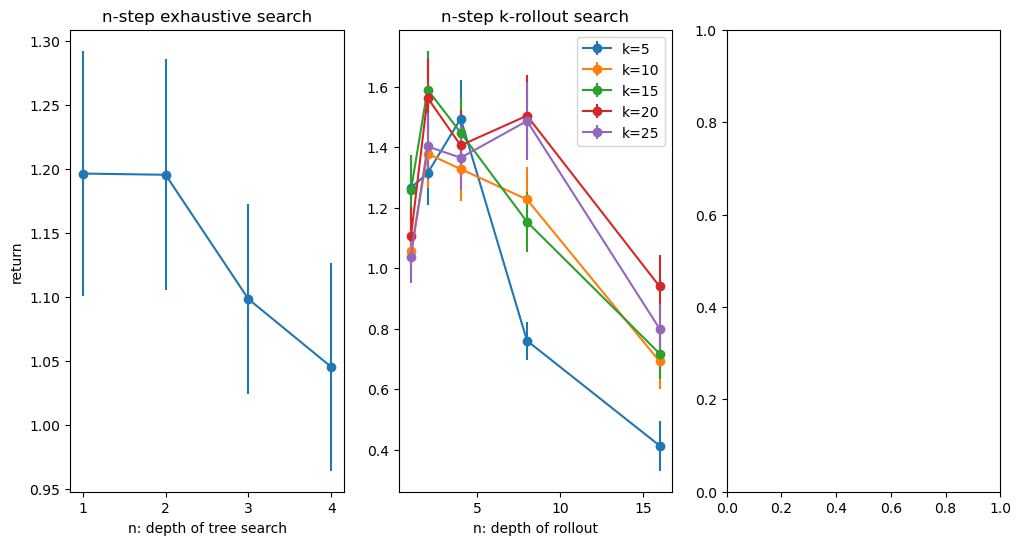

In [190]:
fig, axes = plt.subplots(1, 3, figsize=(12,6))
#axes[0].plot(all_returns.keys(), [np.average(all_returns[x]) for x in all_returns.keys()], ".-")
axes[0].errorbar(all_returns.keys(), 
                 [np.average(all_returns[x]) for x in all_returns.keys()],
                 yerr = [np.std(all_returns[x])/ np.sqrt(len(all_returns[x])) for x in all_returns.keys()],
                 fmt='-o')
axes[0].set_title("n-step exhaustive search")
axes[0].set_ylabel("return")
axes[0].set_xlabel("n: depth of tree search")

ds = [1, 2, 4, 8, 16]
ns = [5, 10, 15, 20, 25]

for n in ns:
    axes[1].errorbar(ds, 
                     [np.average(rollout_returns[n, d]) for d in ds],
                     yerr = [np.std(rollout_returns[n, d])/ np.sqrt(len(rollout_returns[n, d])) for d in ds],
                     fmt='-o',
                     label="k=%d"%n)
    axes[1].set_title("n-step k-rollout search")    
    axes[1].set_xlabel("n: depth of rollout")
    axes[1].legend()

ns = [5, 10, 15, 20, 25, 30, 35, 40,45, 50, 55, 60]    
axes[2].errorbar(ns, 
                 [np.average(mcts_returns[x]) for x in ns],
                 yerr = [np.std(mcts_returns[x])/ np.sqrt(len(mcts_returns[x])) for x in ns],
                 fmt='-o')
axes[2].set_title("MCTS")
axes[2].set_xlabel("n: number of simulations")
    
    
for ax in axes: ax.set_ylim(0.,2.0)

In [123]:
# k-step n-rollout search

rollout_returns = {}
for n in [5, 10, 15, 20, 25]:
    for d in [1, 2, 4, 8, 16]:
        rollout_returns[n, d] = test_model(n, model, flags, eps_n=500, temp=30., mode=1, d=d)

Testing 5-step 1-rollout planning
Finish 500 episode: avg. return: 1.27 (+-0.10) 
Testing 5-step 2-rollout planning
Finish 500 episode: avg. return: 1.31 (+-0.11) 
Testing 5-step 4-rollout planning
Finish 500 episode: avg. return: 1.49 (+-0.13) 
Testing 5-step 8-rollout planning
Finish 500 episode: avg. return: 0.76 (+-0.06) 
Testing 5-step 16-rollout planning
Finish 500 episode: avg. return: 0.41 (+-0.08) 
Testing 10-step 1-rollout planning
Finish 500 episode: avg. return: 1.06 (+-0.09) 
Testing 10-step 2-rollout planning
Finish 500 episode: avg. return: 1.38 (+-0.11) 
Testing 10-step 4-rollout planning
Finish 500 episode: avg. return: 1.33 (+-0.10) 
Testing 10-step 8-rollout planning
Finish 500 episode: avg. return: 1.23 (+-0.11) 
Testing 10-step 16-rollout planning
Finish 500 episode: avg. return: 0.69 (+-0.09) 
Testing 15-step 1-rollout planning
Finish 500 episode: avg. return: 1.26 (+-0.12) 
Testing 15-step 2-rollout planning
Finish 500 episode: avg. return: 1.59 (+-0.13) 
Testing

In [191]:
mcts_returns

NameError: name 'mcts_returns_' is not defined

In [189]:
# MCTS

mcts_returns = {}

parser = argparse.ArgumentParser()
mcts_flags = parser.parse_args([])  
mcts_flags.discounting = 0.97
mcts_flags.pb_c_init = 1.25
mcts_flags.pb_c_base = 19652
mcts_flags.root_dirichlet_alpha = 0.25
mcts_flags.root_exploration_fraction = 0.

for n in [55, 60, 65, 70]:
    mcts_flags.num_simulations = n
    mcts_returns[n]  = test_model(n, model, flags, eps_n=500, temp=0.5, mode=2, mcts_flags=mcts_flags)

Testing MCTS with 55 simulations
Finish 500 episode: avg. return: 1.11 (+-0.10) 
Testing MCTS with 60 simulations
Finish 500 episode: avg. return: 1.39 (+-0.12) 
Testing MCTS with 65 simulations


KeyboardInterrupt: 

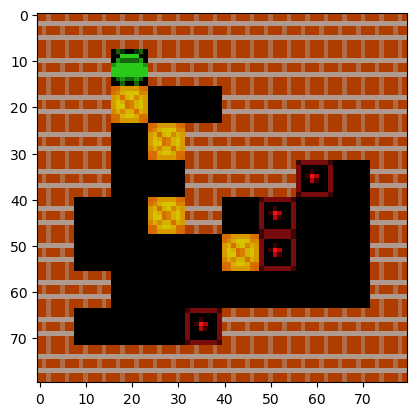

Finish 101 episode: avg. return: 1.14 (+-0.20) 


In [110]:
    
    
parser = argparse.ArgumentParser()      
flags = parser.parse_args([])   

env = SokobanWrapper(gym.make("Sokoban-v0"), noop=True)
env = Environment(env)
env.initial()
obs_shape, num_actions = env.gym_env.observation_space.shape, env.gym_env.action_space.n

parser = argparse.ArgumentParser()
flags = parser.parse_args([])   
flags.discounting = 0.97
flags.pb_c_init = 1.25
flags.pb_c_base = 19652
flags.root_dirichlet_alpha = 0.25
flags.root_exploration_fraction = 0.
flags.num_simulations = 20
flags.temp = 0.5
flags.model_type_nn = 0
flags.device = torch.device("cuda")

eps_n = 100
eps_n_cur = 0

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
model.train(False)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

obs = env.initial()
returns = []
mcts = MCTS(flags, num_actions)
while(len(returns) <= eps_n):
    cur_returns = obs['episode_return']    
    obs = {k:v.to(flags.device) for k, v in obs.items()}
    root, extra_info = mcts.run(model, obs, add_exploration_noise=True)    
    new_action = select_action(root, flags.temp)    
    #plt.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].to(
    #flags.device).clone().cpu(),0,2),0,1), interpolation='nearest')
    #plt.show()
    #print("action selected", new_action)
    #print("===========================================")
    obs = env.step(torch.tensor([new_action]))
    if torch.any(obs['done']):
        returns.extend(cur_returns[obs['done']].numpy())
    if eps_n_cur <= len(returns) and len(returns) > 0: 
        eps_n_cur = len(returns) + 10
print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))

In [ ]:
# Debugging planning algorithm
bsz = 1
env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
obs = env.initial()
state = obs['frame'][0].to(flags.device).clone()
action = torch.zeros(bsz).long().to(flags.device)
encoded = None

In [ ]:
action = torch.Tensor([4]).long().to(flags.device)
obs = env.step(action)
state = obs['frame'][0].to(flags.device).clone()

In [ ]:
plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
device = flags.device

for _ in range(1):
    plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
    plt.show()
    ret = np.zeros((5, 5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(5):
                test_action_seq = [i,j,k]
                test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
                old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
                rs, vs, logits, encodeds = model(state, old_new_actions)
                ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
    print(np.max(ret), (np.max(ret) == ret).nonzero())    
    new_action = torch.Tensor((np.max(ret) == ret).nonzero()[0]).long().to(flags.device)
    #obs = env.step(new_action)
    #state = obs['frame'][0].to(flags.device).clone()
    #action = new_action            

In [ ]:
action, prob, q_ret = n_step_greedy_model(state, action, model, 3, encoded=None, temp=10.)
print("action: ", action)
print("prob: ", prob)
print("q_ret: ", q_ret)

In [ ]:
test_action_seq = [2,3,1]
test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
rs, vs, logits, encodeds = model(state, old_new_actions)
ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
print("rs", rs)
print("vs", vs)
print("logits", logits)
print("ret", ret[i,j,k])

In [ ]:
temp = 10.

bsz = state.shape[0]
device = state.device 
num_actions = model.num_actions    
model.train(False)

q_ret = torch.zeros(bsz, num_actions).to(device)        
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)        

for act in range(num_actions):        
    new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
    old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
    rs, vs, logits, encodeds = model(state, old_new_actions)
    ret = rs[0] + flags.discounting * vs[1]
    rs_act[:, act] = rs[0]
    vs_act[:, act] = vs[1]
    q_ret[:, act] = ret

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

In [ ]:
device = flags.device
net_state = env.clone_state()

bsz = 1
temp = 10.
q_ret = torch.zeros(bsz, num_actions).to(device)      
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)   

net = net.to(device)

for act in range(num_actions):
    obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
    obs = {k:v.to(device) for k, v in obs.items()}   
    ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()
    rs_act[:, act] = obs['reward']
    vs_act[:, act] = net(obs)[0]['baseline']
    q_ret[:, act] = ret
    env.restore_state(net_state)

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
batch = get_batch_m(flags, buffers)
print(torch.max(batch["reward"]), (torch.max(batch["reward"]) == batch["reward"]).nonzero())
print(batch["done"].nonzero())

In [ ]:
# DEBUG LOSS

#batch = get_batch_m(flags, buffers)

model.train(False)

rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
logits = logits[:-1]

target_rewards = batch['reward'][1:]
target_logits = batch['policy_logits'][1:]

target_vs = []
target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0]    

for t in range(vs.shape[0]-1, 0, -1):
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    target_vs.append(new_target_v.unsqueeze(0))
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)

# if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
# rs is stored in the form of r_{t+1}, ..., r_{t+k}
# vs is stored in the form of v_{t}, ..., v_{t+k-1}
# logits is stored in the form of a{t}, ..., a_{t+k-1}

done_masks = []
done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
for t in range(vs.shape[0]):
    done = torch.logical_or(done, batch['done'][t])
    done_masks.append(done.unsqueeze(0))

done_masks = torch.concat(done_masks[:-1], dim=0)

# compute final loss
huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
#rs_loss = torch.sum(huberloss(rs, target_rewards) * (~done_masks).float())
rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~done_masks).float())
#vs_loss = torch.sum(huberloss(vs[:-1], target_vs) * (~done_masks).float())
vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~done_masks).float())
logits_loss = compute_cross_entropy_loss(logits, target_logits, done_masks)

# debug
ind = 10

target_vs = []
target_v = vs[-1]
for t in range(vs.shape[0]-1, 0, -1):        
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    print(t, 
          "reward %2f" % batch['reward'][t,ind].item(), 
          "bootstrap %2f" % (target_v * (~batch['done'][t]).float())[ind].item(), 
          "truncated %2f" % (vs[t-1] * (batch['truncated_done'][t]).float())[ind].item(),
          "vs[t-1] %2f" % vs[t-1][ind].item(),
          "new_targ %2f" % new_target_v[ind].item())
    target_vs.append(new_target_v.unsqueeze(0))    
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)   
print("done", batch["done"][:, ind])
print("done_masks", done_masks[:, ind])
print("vs: ", vs[:, ind])
print("target_vs: ", target_vs[:, ind])
print("reward: ", rs[:, ind])
print("target_reward: ", target_rewards[:, ind])
print("logits: ", logits[:, ind])
print("target_logits: ", target_logits[:, ind])

In [ ]:
def compute_loss_m(model, batch):
    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_rewards = batch['reward'][1:]
    target_logits = batch['policy_logits'][1:]

    target_vs = []
    target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float())# +
                           #vs[t-1] * (batch['truncated_done'][t]).float())
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)

    # if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
    # rs is stored in the form of r_{t+1}, ..., r_{t+k}
    # vs is stored in the form of v_{t}, ..., v_{t+k-1}
    # logits is stored in the form of a{t}, ..., a_{t+k-1}

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
    for t in range(vs.shape[0]):
        done = torch.logical_or(done, batch['done'][t])
        done_masks.append(done.unsqueeze(0))

    done_masks = torch.concat(done_masks[:-1], dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()) * (~done_masks).float())
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()) * (~done_masks).float())
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), done_masks)
    
    return rs_loss, vs_loss, logits_loss

# alt. version of computing loss by treading terminal state as absorbing state (as in MuZero)

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_logits = batch['policy_logits'][1:].clone()
    target_rewards = batch['reward'][1:].clone()

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)

    c_logits = target_logits[0]
    c_state = batch['frame'][0]
    for t in range(vs.shape[0]-1):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        c_logits = torch.where(done.unsqueeze(-1), c_logits, target_logits[t])
        target_logits[t] = c_logits
        c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][t])  
        done_masks.append(done.unsqueeze(0))
    done_masks = torch.concat(done_masks, dim=0)
    done = torch.logical_or(done, batch['done'][-1])
    c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][-1])
    target_rewards = target_rewards * (~done_masks).float()

    target_vs = []
    target_v = model(c_state, batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * target_v
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()))
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()))
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), None)
    
    return rs_loss, vs_loss, logits_loss